## Description
_______

This script generates a bar and whiskers plot for every ESP output found in the directory_path folder.  
The plot includes observed streamflow and optionally, simulated streamflow from a full model run.  
Plot will be generated for date between start_date and end_date so that performance of different forecast  
lead times can be analyzed. 

### Import Libraries

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np

### Inputs

In [2]:
# Define inputs for the plot
directory_path= '../project/58408_esp_results/' # directory containing ESP outputs
start_date= '04-01'       # start date for esp analysis in %Y-%m-%d
end_date= '07-31'         # end date for esp analysis in %Y-%m-%d
output_directory= '../'   # directory for outputs

In [3]:
# adding computed runoff for given year (optional, replace with False if not using)
computed_path= '../0058408.txt'

### Generate Plot

In [4]:
# Extract month and day from the dates
start_month, start_day = start_date.split('-')
end_month, end_day = end_date.split('-')

# Convert dates to integers
start_month, start_day = int(start_month), int(start_day)
end_month, end_day = int(end_month), int(end_day)

In [5]:
# Initialize an empty list to store the total simulated runoff for each ensemble member
all_sum_cout_series = []

# Initialize an empty list to store the total observed runoff for each ensemble member
all_sum_rout_series = []

In [6]:
if computed_path is not None:
    # Read the DataFrame from the computed_path
    sim = pd.read_csv(computed_path, sep='\t', index_col=0)

    sim = sim.drop('UNITS', axis=0)

    # Convert index to datetime format
    sim.index = pd.to_datetime(sim.index, errors='coerce')
    
    sum_model_sim= []
    
        # Convert 'cout' column to numeric if needed
    sim['cout'] = pd.to_numeric(sim['cout'], errors='coerce')


In [7]:
# Iterate through each .nc file in the directory
for filename in os.listdir(directory_path):
    if filename.endswith('.nc'):
        # Construct the full file path
        file_path = os.path.join(directory_path, filename)
        
        # Open the esp output file
        esp = xr.open_dataset(file_path)
        
        # Convert all data variable values to float
        esp = esp.astype(float)
        
        # Convert 'DATE' coordinate to datetime format
        esp['DATE'] = pd.to_datetime(esp['DATE'])
        
        # Extract the year from the last DATE
        last_date_year = pd.to_datetime(esp['DATE'][-1].values).year
        
        # Create start_date and end_date for the analysis period
        start_date = pd.Timestamp(year=last_date_year, month=start_month, day=start_day)
        end_date = pd.Timestamp(year=last_date_year, month=end_month, day=end_day)
        
        # Select data between start_date and end_date 
        ds_selected = esp.sel(DATE=slice(start_date, end_date))
        
        # Sum 'cout' variable for each ensemble member
        sum_cout = ds_selected['cout'].sum(dim='DATE')
        sum_rout= ds_selected['rout'].sum(dim='DATE')
        
        # Convert sum_cout to pandas Series
        sum_cout_series = sum_cout.to_series()
        sum_rout_series = sum_rout.to_series()
        
        # Ensure the simulated index is a DatetimeIndex and add year of analysis to series
        sum_cout_series.index = pd.to_datetime(sum_cout_series.index)
        sum_cout_series.index = sum_cout_series.index.map(lambda x: x.replace(year=last_date_year))
        
        # Ensure the observed index is a DatetimeIndex and add year of analysis to series
        sum_rout_series.index = pd.to_datetime(sum_rout_series.index)
        sum_rout_series.index = sum_rout_series.index.map(lambda x: x.replace(year=last_date_year))
        
        if computed_path is not None:
            # Trim the DataFrame based on the date range
            model_sim = sim.loc[start_date:end_date]
            
            # Sum the 'cout' column
            sum_sim = model_sim['cout'].sum()
            
            sim_series= sum_rout_series.copy()
            
            sim_series[:]= sum_sim
            
            sim_series.name = 'sim'
            
            sum_model_sim.append(sim_series)
        
        # Append the simulated and observed series to the list
        all_sum_cout_series.append(sum_cout_series)
        all_sum_rout_series.append(sum_rout_series)


In [8]:
# Concatenate all sum_cout_series into a single series
sum_cout_series_combined = pd.concat(all_sum_cout_series)
sum_rout_series_combined = pd.concat(all_sum_rout_series)

In [9]:
# Assuming sum_rout_series_combined is your pandas Series
sum_rout_series_combined = sum_rout_series_combined.where(sum_rout_series_combined >= 0, np.nan)

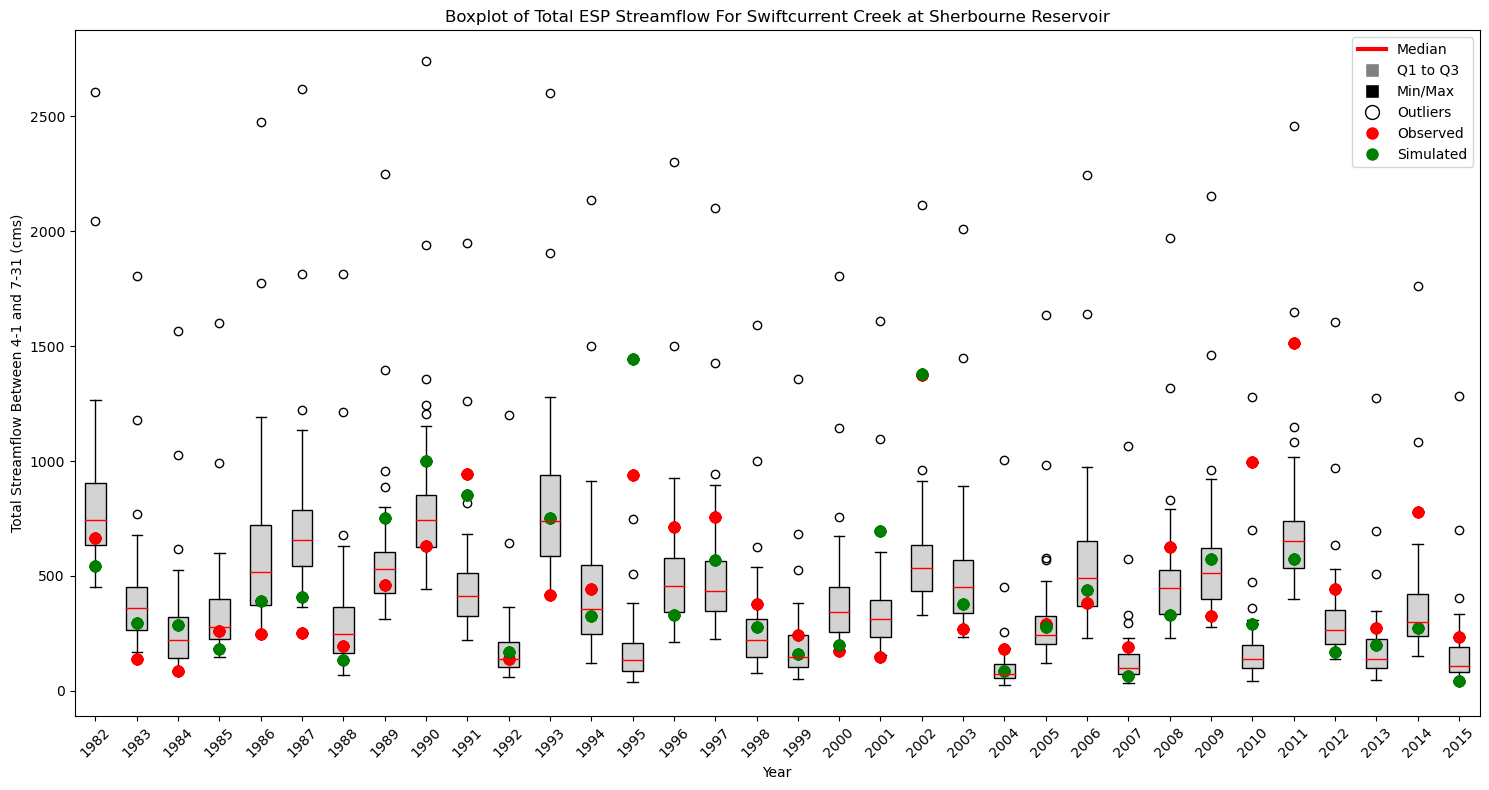

In [10]:
# Extract simulated data for each unique year 
data = [sum_cout_series_combined[sum_cout_series_combined.index.year == year].values 
        for year in sum_cout_series_combined.index.year.unique()]

# Initialize plot size
plt.figure(figsize=(15, 8))

# Create boxplot of simulated flow with modified box properties
box = plt.boxplot(data, labels=sum_cout_series_combined.index.year.unique(), patch_artist=True, 
                  medianprops=dict(color='red'), boxprops=dict(color='black', facecolor='lightgray'))

# Tilt x-axis labels
plt.gca().tick_params(axis='x', rotation=45)

# Set plot title and labels
plt.title('Boxplot of Total ESP Streamflow For Swiftcurrent Creek at Sherbourne Reservoir')
plt.xlabel('Year')
plt.ylabel(f'Total Streamflow Between {start_month}-{start_day} and {end_month}-{end_day} (cms)')

# Extract and plot scatter data for observed flow
for i, year in enumerate(sum_cout_series_combined.index.year.unique(), start=1):
    y = sum_rout_series_combined[sum_rout_series_combined.index.year == year].values
    # Add some random "jitter" to the x-axis
    x = np.random.normal(i, 0.0000001, size=len(y))  # plot all dots together
    plt.plot(x, y, 'r.', alpha=0.2, markersize=15, label='Observed' if i == 1 else "")

# Add legend
legend_labels = ['Median', 'Q1 to Q3', 'Min/Max', 'Outliers', 'Observed']
legend_colors = ['red', 'grey', 'black', 'black', 'red']    
    
if computed_path is not None:
    sum_model_sim_combined= pd.concat(sum_model_sim)
    # Plot actual model simulated flow
    for i, year in enumerate(sum_cout_series_combined.index.year.unique(), start=1):
        y = sum_model_sim_combined[sum_model_sim_combined.index.year == year].values
        # Add some random "jitter" to the x-axis
        x = np.random.normal(i, 0.00001, size=len(y))  # plot all dots together
        plt.plot(x, y, 'g.', alpha=0.2, markersize=15, label='Simulated' if i == 1 else "")
        
    # Update legend 
    legend_labels = ['Median', 'Q1 to Q3', 'Min/Max', 'Outliers', 'Observed', 'Simulated']
    legend_colors = ['red', 'grey', 'black', 'black', 'red', 'green']

# Create legend patches
legend_patches = [
    plt.Line2D([0], [0], color=color, linewidth=3, label=label) if label == 'Median' or label == 'Whiskers (Min/Max)'
    else plt.Line2D([0], [0], marker='o', color='w', label=label, 
                    markerfacecolor=color, markersize=10) if label == 'Observed' or label == 'Simulated'
    else plt.Line2D([0], [0], marker='s', color='w', label=label, 
                    markerfacecolor=color, markersize=10)  # Square marker for 'Q1 to Q3'
    if label != 'Outliers'
    else plt.Line2D([0], [0], marker='o', color='w', label=label, 
                    markerfacecolor='none', markersize=10, markeredgecolor='black')  # Clear circle for 'Outliers'
    for label, color in zip(legend_labels, legend_colors)
]


# Add legend to plot
plt.legend(handles=legend_patches, loc='upper right')

# Save the plot to the specified directory
save_path = os.path.join(output_directory, '208_boxplot.png')
plt.savefig(save_path)

# Show plot
plt.tight_layout()
plt.show()

In [11]:
# Initialize counters
within_box_sim = 0
within_whiskers_sim = 0
outside_whiskers_sim = 0

# Iterate through each year and simulated flow value
for i, year in enumerate(sum_cout_series_combined.index.year.unique()):
    simulated_flow = sum_model_sim_combined[sum_model_sim_combined.index.year == year].values
    box_values = data[i]
    
    # Iterate through each simulated flow value
    for flow_value in simulated_flow:
        # Check if simulated flow is within the box
        if np.percentile(box_values, 25) <= flow_value <= np.percentile(box_values, 75):
            within_box_sim += 1
        # Check if simulated flow is within the whiskers
        elif np.min(box_values) <= flow_value <= np.max(box_values):
            within_whiskers_sim += 1
        # Simulated flow is outside whiskers
        else:
            outside_whiskers_sim += 1

# Calculate percentages
total_simulated = within_box_sim + within_whiskers_sim + outside_whiskers_sim
percentage_within_box_sim = (within_box_sim / total_simulated) * 100
percentage_within_whiskers_sim = (within_whiskers_sim / total_simulated) * 100
percentage_outside_whiskers_sim = (outside_whiskers_sim / total_simulated) * 100

# Print results
print("Percentage of simulated flow within the box:", percentage_within_box_sim)
print("Percentage of simulated flow within the whiskers but outside the box:", percentage_within_whiskers_sim)
print("Percentage of simulated flow outside the whiskers:", percentage_outside_whiskers_sim)

Percentage of simulated flow within the box: 47.05882352941176
Percentage of simulated flow within the whiskers but outside the box: 50.0
Percentage of simulated flow outside the whiskers: 2.941176470588235
